In [1]:
from dotenv import  load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

In [2]:
from langchain_core.tools import tool

@tool 
def add(a: int, b:int) -> int:
 
    """ 
    숫자 a와 b를 더합니다. 
    """
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """ 
    숫자 a와 b를 곱합니다. 
    """
    return a * b

In [3]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply]

llm_with_tools = small_llm.bind_tools(tool_list) 
 
tool_node = ToolNode(tool_list) 


In [4]:
query = '3 곱하기 5는?'

In [5]:
ai_message = llm_with_tools.invoke(query) 
ai_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Jhq4BTMw4IpwdzP3CmGxRbCh', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 84, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b39fe-fb95-7ca0-9cb9-8731be5374fe-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 5}, 'id': 'call_Jhq4BTMw4IpwdzP3CmGxRbCh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 17, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
tool_node.invoke({'messages':[ai_message]}) 

{'messages': [ToolMessage(content='15', name='multiply', tool_call_id='call_Jhq4BTMw4IpwdzP3CmGxRbCh')]}

In [7]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [8]:
def agent(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

In [9]:
def should_continue(state: MessagesState):
    messages = state['messages']
    last_ai_message = messages[-1]
    
    if last_ai_message.tool_calls:
        return 'tools'
    return 'end'

In [10]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tool_node', tool_node)

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')

graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    {
        'tools': 'tool_node',
        'end': END
    },
)

graph_builder.add_edge('tool_node', 'agent')

In [12]:
graph = graph_builder.compile()

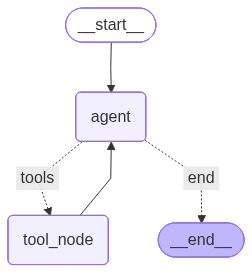

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage('3에다 5를 더하고 거기에 8을 곱하면?')]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3에다 5를 더하고 거기에 8을 곱하면?
================================== Ai Message ==================================
Tool Calls:
  add (call_gHweUywWsRHQQFXwjXvk412o)
 Call ID: call_gHweUywWsRHQQFXwjXvk412o
  Args:
    a: 3
    b: 5
  multiply (call_I4LNe6KYg2a3IVq0i7o264Jc)
 Call ID: call_I4LNe6KYg2a3IVq0i7o264Jc
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: multiply

40
================================== Ai Message ==================================
Tool Calls:
  multiply (call_pmZkdwJ2DTUTx1CWKpLozB0I)
 Call ID: call_pmZkdwJ2DTUTx1CWKpLozB0I
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: multiply

64
================================== Ai Message ==================================

3에 5를 더하면 8이 되고, 그에 8을 곱하면 64가 됩니다. 따라서 결과는 64입니다.
